# Preprocesamiento de datos

## 1. Introducción

El aprendizaje automático se ha convertido en una herramienta esencial para la clasificación, análisis y procesamiento de información en distintas áreas de la ciencia. En particular, la botánica enfrenta el reto de manejar grandes cantidades de imágenes de hojas de distintas especies, las cuales pueden presentar variaciones en iluminación, tamaño y calidad.

El presente documento describe el preprocesamiento de datos realizado para el proyecto de clasificación automática de hojas de Costa Rica. Este preprocesamiento es esencial para mejorar la calidad del dataset y preparar las imágenes para el entrenamiento de una red neuronal convolucional (CNN), asegurando que el modelo aprenda de manera eficiente y precisa, minimizando problemas de overfitting o underfitting.

## 2. Materiales y métodos

### Importar librerías

In [2]:
import os
import pandas as pd
import cv2
import shutil
import random
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import (
    ImageDataGenerator,
    array_to_img,
    img_to_array,
    load_img,
)

### Exploración inicial del dataset

In [3]:
# Ruta del dataset original
dataset_path = "./All_CR_Leaves_Cleaned"

# Exploración inicial
all_classes = []
dir_elements = sorted(os.listdir(dataset_path))

for class_name in dir_elements:
    class_path = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_path):
        images = [
            f
            for f in os.listdir(class_path)
            if f.lower().endswith((".png", ".jpg", ".jpeg"))
        ]
        all_classes.append([class_name, len(images)])

classes_DF = pd.DataFrame(
    all_classes, columns=["Class", "Number of Images"]
).sort_values(by="Number of Images", ascending=False)
print(f"Número de clases originales: {len(classes_DF)}")
classes_DF.head()

Número de clases originales: 255


,Class,Number of Images
242,Terminalia amazonia,89
40,Calycophyllum candidissimum,76
237,Tabebuia ochracea,67
233,Swietenia macrophylla,66
156,Manilkara chicle,65


### Visualización inicial

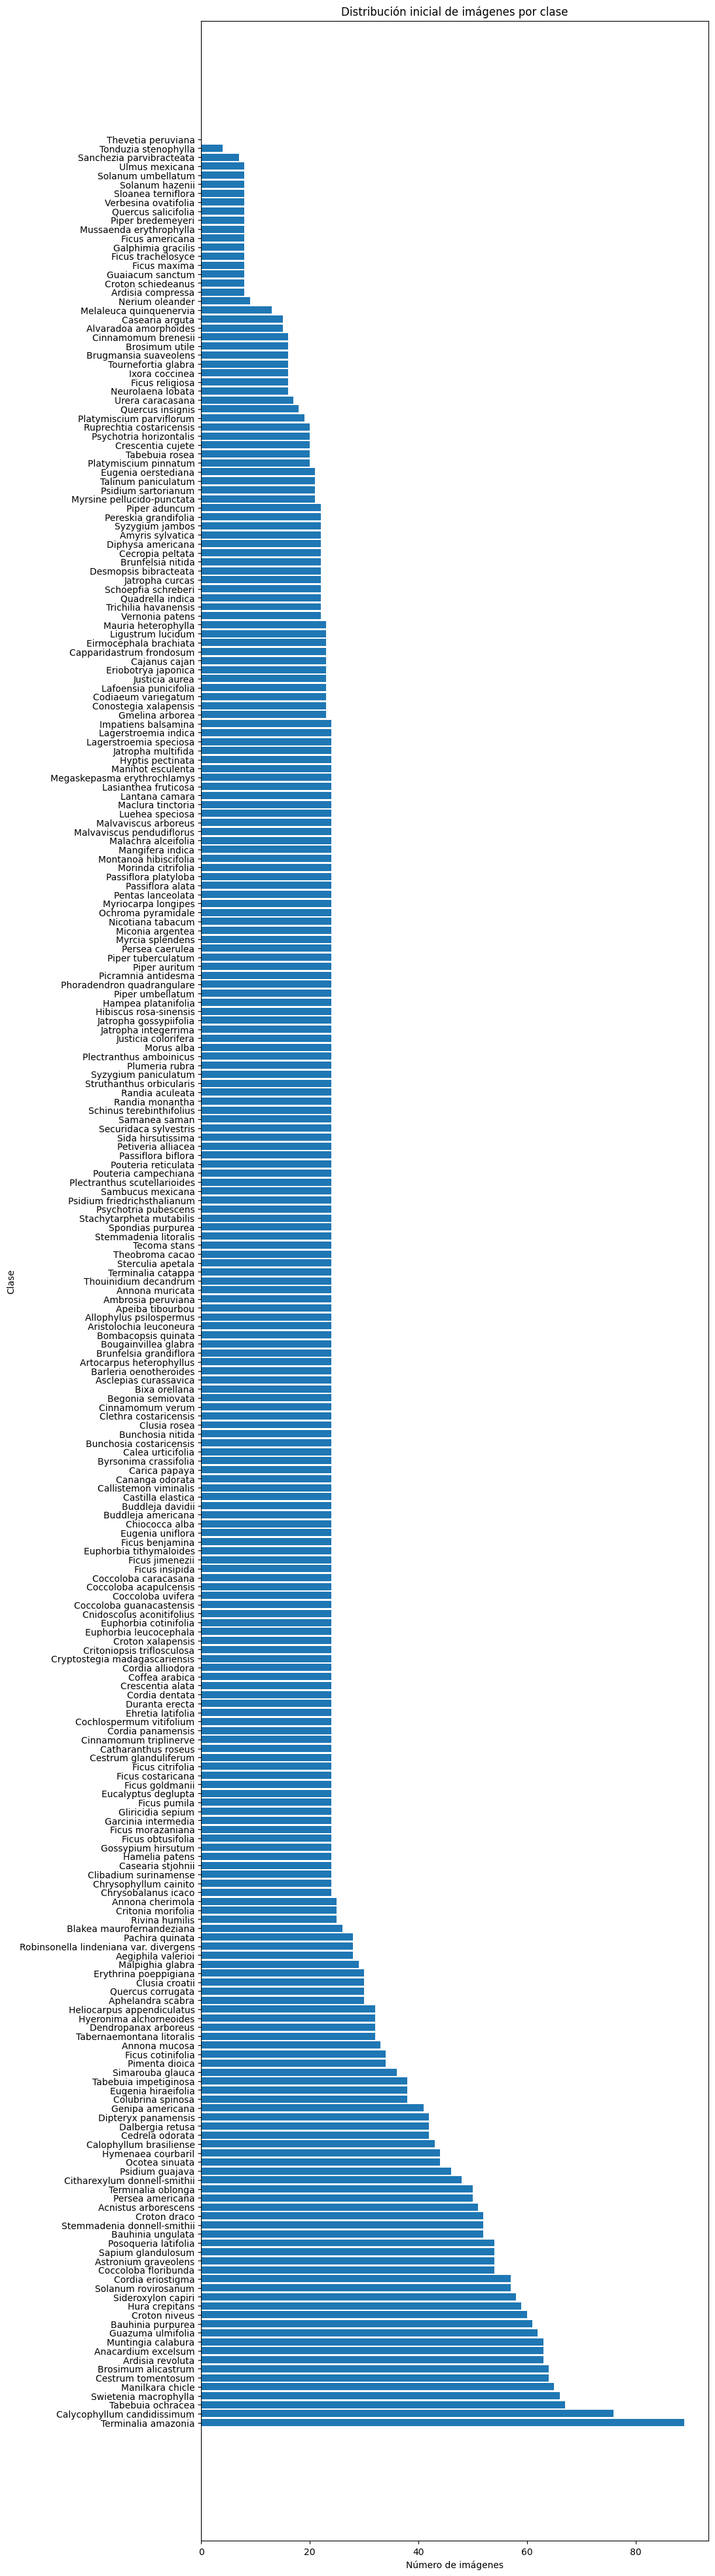

In [4]:
plt.figure(figsize=(10, 50))
plt.barh(classes_DF["Class"], classes_DF["Number of Images"])
plt.title("Distribución inicial de imágenes por clase")
plt.xlabel("Número de imágenes")
plt.ylabel("Clase")
plt.show()

### Filtrado de clases con menos de 10 imágenes

In [5]:
filtered_classes_DF = classes_DF[classes_DF["Number of Images"] >= 10]
print(
    f"Clases después del filtrado (< 10 imágenes eliminadas): {len(filtered_classes_DF)}"
)
filtered_classes_DF.head()

filtered_classes_DF.to_csv("filtered_dataset_summary.csv", index=False)

Clases después del filtrado (< 10 imágenes eliminadas): 236


###  Reescalado de imágenes

In [10]:
input_dir = "./All_CR_Leaves_Cleaned"
output_dir = "./filtered_leaves"
img_size = (64, 64)

# Crear carpeta destino si no existe
os.makedirs(output_dir, exist_ok=True)

for class_name in os.listdir(input_dir):
    class_path = os.path.join(input_dir, class_name)
    if os.path.isdir(class_path):
        output_class_path = os.path.join(output_dir, class_name)
        os.makedirs(output_class_path, exist_ok=True)

        for img_name in os.listdir(class_path):
            if img_name.lower().endswith((".jpg", ".jpeg", ".png")):
                src_img_path = os.path.join(class_path, img_name)
                dst_img_path = os.path.join(output_class_path, img_name)

                img = cv2.imread(src_img_path)
                if img is None:
                    print(f"⚠ Imagen inválida: {src_img_path}")
                    continue

                h, w = img.shape[:2]
                # Calcular factor de escala para mantener aspecto sin superar img_size
                scale = min(img_size[0] / w, img_size[1] / h)
                new_w = int(w * scale)
                new_h = int(h * scale)

                # Redimensionar manteniendo aspecto
                resized_img = cv2.resize(
                    img, (new_w, new_h), interpolation=cv2.INTER_AREA
                )

                # Crear imagen de fondo con el color del píxel superior izquierdo
                top_left_color = img[0, 0].tolist()
                padded_img = np.full(
                    (img_size[1], img_size[0], 3), top_left_color, dtype=np.uint8
                )

                # Calcular coordenadas de inserción para centrar la imagen
                x_offset = (img_size[0] - new_w) // 2
                y_offset = (img_size[1] - new_h) // 2

                # Pegar la imagen redimensionada en el centro
                padded_img[y_offset : y_offset + new_h, x_offset : x_offset + new_w] = (
                    resized_img
                )

                # Guardar imagen
                cv2.imwrite(dst_img_path, padded_img)

print("✅ Reescalado con padding aplicado correctamente en filtered_leaves")

✅ Reescalado con padding aplicado correctamente en filtered_leaves


### Data Augmentation

In [11]:
input_dir = "./filtered_leaves"
output_dir = "./augmented_leaves"

os.makedirs(output_dir, exist_ok=True)

datagen = ImageDataGenerator(
    rotation_range=25,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest",
)

target_per_class = 50

for class_name in os.listdir(input_dir):
    class_input_dir = os.path.join(input_dir, class_name)
    if os.path.isdir(class_input_dir):
        class_output_dir = os.path.join(output_dir, class_name)
        os.makedirs(class_output_dir, exist_ok=True)

        images_list = [
            img_name
            for img_name in os.listdir(class_input_dir)
            if img_name.lower().endswith((".jpg", ".jpeg", ".png"))
        ]
        num_images = len(images_list)

        # ❗ Si no hay imágenes válidas, saltar clase
        if num_images == 0:
            print(
                f"⚠ Clase '{class_name}' está vacía o sin imágenes válidas. Saltando."
            )
            continue

        # Copiar todas las originales primero
        for img_name in images_list:
            src = os.path.join(class_input_dir, img_name)
            dst = os.path.join(class_output_dir, img_name)
            if not os.path.exists(dst):
                shutil.copy2(src, dst)

        if num_images >= target_per_class:
            print(
                f"✔ Clase '{class_name}' ya tiene {num_images} imágenes, no requiere augmentación."
            )
            continue

        needed = target_per_class - num_images
        print(
            f"⚡ Clase '{class_name}' tiene {num_images} imágenes. Generando {needed} imágenes adicionales..."
        )

        # Generar imágenes adicionales seleccionando aleatoriamente cualquier imagen de la clase
        i = 0
        while i < needed:
            sample_img_name = random.choice(images_list)
            sample_img_path = os.path.join(class_input_dir, sample_img_name)
            img = load_img(sample_img_path)
            x = img_to_array(img)
            x = x.reshape((1,) + x.shape)

            for batch in datagen.flow(
                x,
                batch_size=1,
                save_to_dir=class_output_dir,
                save_prefix="aug",
                save_format="jpg",
            ):
                i += 1
                if i >= needed:
                    break

print("✅ Data augmentation completada SOLO para clases con menos de 50 imágenes.")

✔ Clase 'Acnistus arborescens' ya tiene 51 imágenes, no requiere augmentación.
⚡ Clase 'Aegiphila valerioi' tiene 28 imágenes. Generando 22 imágenes adicionales...
⚡ Clase 'Allophylus psilospermus' tiene 24 imágenes. Generando 26 imágenes adicionales...
⚡ Clase 'Alvaradoa amorphoides' tiene 15 imágenes. Generando 35 imágenes adicionales...
⚡ Clase 'Ambrosia peruviana' tiene 24 imágenes. Generando 26 imágenes adicionales...
⚡ Clase 'Amyris sylvatica' tiene 22 imágenes. Generando 28 imágenes adicionales...
✔ Clase 'Anacardium excelsum' ya tiene 63 imágenes, no requiere augmentación.
⚡ Clase 'Annona cherimola' tiene 25 imágenes. Generando 25 imágenes adicionales...
⚡ Clase 'Annona mucosa' tiene 33 imágenes. Generando 17 imágenes adicionales...
⚡ Clase 'Annona muricata' tiene 24 imágenes. Generando 26 imágenes adicionales...
⚡ Clase 'Apeiba tibourbou' tiene 24 imágenes. Generando 26 imágenes adicionales...
⚡ Clase 'Aphelandra scabra' tiene 30 imágenes. Generando 20 imágenes adicionales...


### Dejar 50 imagenes por clase

In [12]:
# Carpeta donde están las imágenes ya augmentadas o combinadas
input_dir = "./augmented_leaves"

# ✅ Recorrer cada clase
for class_name in os.listdir(input_dir):
    class_dir = os.path.join(input_dir, class_name)
    if os.path.isdir(class_dir):
        images_list = [
            img_name
            for img_name in os.listdir(class_dir)
            if img_name.lower().endswith((".jpg", ".jpeg", ".png"))
        ]

        num_images = len(images_list)

        if num_images > 50:
            # Elegir aleatoriamente 50 imágenes para mantener
            selected_images = random.sample(images_list, 50)

            # Eliminar las imágenes que no están en la lista seleccionada
            for img_name in images_list:
                if img_name not in selected_images:
                    os.remove(os.path.join(class_dir, img_name))

            print(
                f"⚠ Clase '{class_name}' tenía {num_images} imágenes, se redujo a 50."
            )

        elif num_images < 50:
            print(
                f"⚡ Clase '{class_name}' tiene solo {num_images} imágenes, no fue reducida (necesita augmentación previa)."
            )

        else:
            print(f"✔ Clase '{class_name}' ya tiene 50 imágenes exactas, no se toca.")

print("✅ Reducción completada: todas las clases tienen máximo 50 imágenes.")

⚠ Clase 'Acnistus arborescens' tenía 51 imágenes, se redujo a 50.
✔ Clase 'Aegiphila valerioi' ya tiene 50 imágenes exactas, no se toca.
✔ Clase 'Allophylus psilospermus' ya tiene 50 imágenes exactas, no se toca.
✔ Clase 'Alvaradoa amorphoides' ya tiene 50 imágenes exactas, no se toca.
✔ Clase 'Ambrosia peruviana' ya tiene 50 imágenes exactas, no se toca.
✔ Clase 'Amyris sylvatica' ya tiene 50 imágenes exactas, no se toca.
⚠ Clase 'Anacardium excelsum' tenía 63 imágenes, se redujo a 50.
✔ Clase 'Annona cherimola' ya tiene 50 imágenes exactas, no se toca.
✔ Clase 'Annona mucosa' ya tiene 50 imágenes exactas, no se toca.
⚡ Clase 'Annona muricata' tiene solo 49 imágenes, no fue reducida (necesita augmentación previa).
✔ Clase 'Apeiba tibourbou' ya tiene 50 imágenes exactas, no se toca.
✔ Clase 'Aphelandra scabra' ya tiene 50 imágenes exactas, no se toca.
✔ Clase 'Ardisia compressa' ya tiene 50 imágenes exactas, no se toca.
⚠ Clase 'Ardisia revoluta' tenía 63 imágenes, se redujo a 50.
✔ Cl

## Discusión de resultados

## Avance y revisión del plan

## Conclusiones